### Load models


In [1]:
import os
import sys
import re
import pickle as pkl
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import rc

sys.path.append("../")
# Import dataloaders
import data_utils.ood_detection.cifar10 as cifar10
import data_utils.ood_detection.cifar100 as cifar100
import data_utils.ood_detection.lsun as lsun
import data_utils.ood_detection.svhn as svhn
import data_utils.ood_detection.mnist as mnist
import data_utils.ood_detection.tiny_imagenet as tiny_imagenet

# Network architectures
from net.lenet import lenet
from net.resnet import resnet50
from net.vgg import vgg16
from net.wide_resnet import wrn
from net.vit import vit

from utils.gmm_utils import get_embeddings, gmm_evaluate, gmm_fit, maxp_evaluate, gmm_evaluate_with_perturbation, maxp_evaluate_with_perturbation
from metrics.uncertainty_confidence import entropy, logsumexp, confidence, sumexp, maxval
from metrics.ood_metrics import get_roc_auc, get_roc_auc_logits

In [2]:
device = torch.device("cuda:1")
# Dataset params
dataset_num_classes = {"cifar10": 10, "cifar100": 100, "svhn": 10, "lsun": 10, "tiny_iamgenet": 200}
dataset_loader = {"cifar10": cifar10, "cifar100": cifar100, "svhn": svhn, "mnist": mnist, "lsun": lsun, "tiny_imagenet": tiny_imagenet}

# Mapping model name to model function
models = {
    "lenet": lenet,
    "resnet50": resnet50,
    "wide_resnet": wrn,
    "vgg16": vgg16,
    "vit":vit
}

model_to_num_dim = {"resnet18": 512, "resnet50": 2048, "resnet101": 2048, "resnet152": 2048, "wide_resnet": 640, "vgg16": 512,"vit":768}

batch_size = 512
dataset = "cifar10"
ood_dataset = "svhn"
dataset_root = "../data"
# model = "vgg16"
# saved_model_name = "../saved_models/run17/vgg16_sn_3.0_mod_seed_1/2024_05_27_17_51_26/vgg16_sn_3.0_mod_seed_1_best.model"


model = "vit"
saved_model_name = "../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/vit_sn_3.0_mod_seed_1_best.model"

# Taking input for the dataset
num_classes = dataset_num_classes[dataset]

In [3]:
train_loader, val_loader = dataset_loader[dataset].get_train_valid_loader(
    root=dataset_root,
    batch_size=batch_size,
    augment=False,
    val_seed=1,
    val_size=0.1,
)

#load model
print(f"load {saved_model_name}")
net = models[model](
    spectral_normalization=True,
    mod=True,
    num_classes=num_classes,
    temp=1.0,
).to(device)

net.load_state_dict(torch.load(str(saved_model_name), map_location=device), strict=True)
_ = net.eval()

load ../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/vit_sn_3.0_mod_seed_1_best.model


In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)


def plot_density(results, binrange, bins, title, xlabel):

    plt.figure(figsize=(5, 3))
    plt.tight_layout()

    plt.hist(results[0], density=True, color='r', range=binrange, bins=bins, alpha=0.5, label="org")
    plt.hist(results[1], density=True, color='b', range=binrange, bins=bins, alpha=0.5, label="ood")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(label=title)
    plt.legend()


if not os.path.exists(f"pngs/{model}"):
    os.makedirs(f"pngs/{model}")

In [5]:
cache_path = re.sub(r"[^/]*_best.model", "cache", saved_model_name)

if os.path.exists(cache_path):
    print(f"load cache from {cache_path}")
    with open(cache_path, 'rb') as file:
        cache = pkl.load(file)
        embeddings = cache["embeddings"].to(device)
        labels = cache["labels"].to(device)
        norm_threshold = cache["norm_threshold"]
else:
    embeddings, labels, norm_threshold = get_embeddings(
        net,
        train_loader,
        num_dim=model_to_num_dim["vit"],
        dtype=torch.double,
        device=device,
        storage_device=device,
    )
    cache = {"embeddings": embeddings.cpu(), "labels": labels.cpu(), "norm_threshold": norm_threshold}
    with open(cache_path, "wb") as f:
        pkl.dump(cache, f)
gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings, labels=labels, num_classes=num_classes)

load cache from ../saved_models/run22/vit_sn_3.0_mod_seed_1/2024_09_21_16_49_54/cache


In [6]:
def calculate_gradients_norm(
    net,
    gaussians_model,
    layer_name,
    loader,
    device,
    wrt="input",
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
    norm=1,
):
    layer_grad = None

    def bp_hook(module, grad_input, grad_output):
        # 获取中间层梯度信息
        nonlocal layer_grad
        # print(len(grad_input))
        input_grad = grad_input[0] 
        # w_grad = grad_input[0]
        # input_grad = grad_input[2]#TODO: 当使用sn时，conv层的bias都为false，这时候这样的,当bias为true时候，需要再次验证???
        if wrt == "input":
            layer_grad = torch.norm(input_grad, p=norm)   #1-norm
        # elif wrt == "weight":
        #     layer_grad = w_grad
        else:
            raise ValueError(f"{wrt} is invalid...")
        
    norms = []

    std = torch.tensor(std).to(device)
    mean = torch.tensor(mean).to(device)
    loss_func = nn.CrossEntropyLoss()
    start = 0
    if layer_name in ["image"]:
        print(f"register backward hook for {layer_name}")
        handler = net.conv_proj.register_backward_hook(bp_hook)
    elif layer_name in range(12):
        print(f"register backward hook for {layer_name}")
        handler = net.encoder.layers[layer_name].mlp[0].register_backward_hook(bp_hook)
    else:
        raise ValueError(f"{layer_name} is invalid...")

    cnt = 0
    for data, label in tqdm(loader, dynamic_ncols=True):
        data = data.to(device)
        label = label.to(device)

        data.requires_grad = True  #data.required_grad区分,用required_grad梯度为None
        out = net(data)
        uniform = torch.ones_like(out).to(device)
        _, pred = torch.max(out, 1)

        # #1. 第一种形式loss,log_density
        embedding = net.feature
        log_probs = gaussians_model.log_prob(embedding[:, None, :])
        max_log_probs = log_probs.max(1, keepdim=True)[0]  # get the index of the max log-probability
        loss = max_log_probs.sum()

        # # #2. 第二种形式loss,crossEntropy
        # loss = loss_func(out, pred)

        net.zero_grad()
        loss.backward()

        norms.append(layer_grad.cpu().detach())

        cnt += data.shape[0]
        if cnt > 1000:
            break

    return torch.tensor(norms)

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032
register backward hook for image


100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


register backward hook for image


100%|██████████| 1000/1000 [00:35<00:00, 27.89it/s]


grad norm for image:m2_auroc:0.865555,m2_auprc:0.8357959880335318


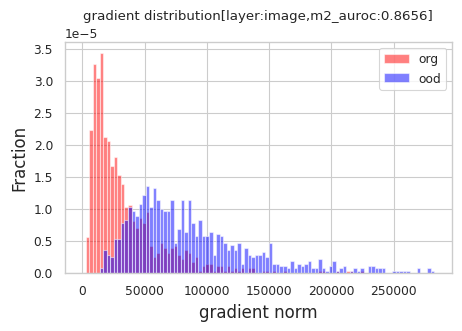

In [7]:
layer = "image"
wrt = "input"
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    test_loader,
    device=device,
    wrt=wrt,
    norm=1,
)
ood_gradient_norms = calculate_gradients_norm(
    net,
    gaussians_model,
    layer,
    ood_test_loader,
    device=device,
    norm=1,
)

right = int(max(gradient_norms.quantile(0.99).item(), ood_gradient_norms.quantile(0.99).item()))
m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(gradient_norms, ood_gradient_norms, None, device, conf=False)
print(f"grad norm for {layer}:m2_auroc:{m2_auroc},m2_auprc:{m2_auprc}")
plot_density([gradient_norms.numpy(), ood_gradient_norms.numpy()],
             binrange=[0, right + 50],
             bins=100,
             title=f"gradient distribution[layer:{layer},m2_auroc:{m2_auroc:.4f}]",
             xlabel="gradient norm")
plt.savefig(f'pngs/{model}/{layer}_grad_wrt_input_dist.png', bbox_inches='tight')

### Compute feature density


In [8]:
test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=512)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=512)
logits, labels, preds = gmm_evaluate(
    net,
    gaussians_model,
    test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)

ood_logits, ood_labels, _ = gmm_evaluate(
    net,
    gaussians_model,
    ood_test_loader,
    device=device,
    num_classes=num_classes,
    storage_device=device,
)
m1_fpr95, m1_auroc, m1_auprc = get_roc_auc_logits(logits, ood_logits, maxval, device, conf=True)

test_loader = dataset_loader[dataset].get_test_loader(root=dataset_root, batch_size=1)
ood_test_loader = dataset_loader[ood_dataset].get_test_loader(root=dataset_root, batch_size=1)
for epsilon in [0.01]:
    logits2, labels2, preds2, acc, acc_perturb = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    ood_logits2, ood_labels2, _, _, _ = gmm_evaluate_with_perturbation(
        net,
        gaussians_model,
        ood_test_loader,
        device=device,
        num_classes=num_classes,
        storage_device=device,
        perturbation="fgsm",
        epsilon=epsilon,
    )
    m2_fpr95, m2_auroc, m2_auprc = get_roc_auc_logits(logits2, ood_logits2, maxval, device, conf=True)
    print(f"noise-:m1_auroc:{m1_auroc:.4f},m1_auprc:{m1_auprc:.4f};noise+:epsilon:{epsilon},m2_auroc:{m2_auroc:.4f},m2_auprc:{m2_auprc:.4f}")

Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Using downloaded and verified file: ../data/svhn/test_32x32.mat
svhn test:26032


100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]

noise-:m1_auroc:0.9303,m1_auprc:0.9522;noise+:epsilon:0.01,m2_auroc:0.9727,m2_auprc:0.9793


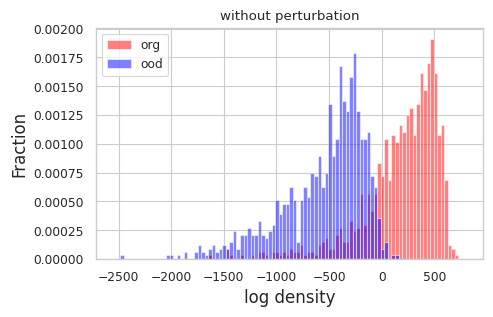

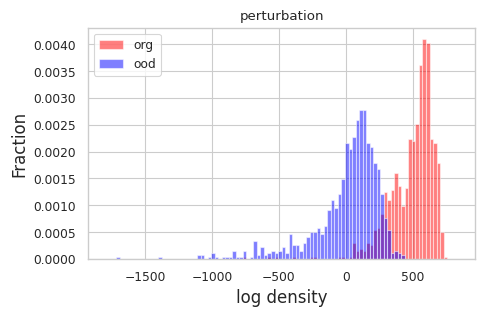

In [9]:
logp = maxval(logits)
logp2 = maxval(logits2)
ood_logp = maxval(ood_logits)
ood_logp2 = maxval(ood_logits2)
left1 = int(min(logp.quantile(0).item(), ood_logp.quantile(0).item()))
right1 = int(max(logp.quantile(1).item(), ood_logp.quantile(1).item()))
plot_density([logp.cpu().numpy(), ood_logp.cpu().numpy()],
             binrange=[left1 - 100, right1 + 100],
             bins=100,
             title="without perturbation",
             xlabel="log density")
plt.savefig(f'pngs/{model}/logdensity_hist.png', bbox_inches='tight')
left2 = int(min(logp2.quantile(0).item(), ood_logp2.quantile(0).item()))
right2 = int(max(logp2.quantile(1).item(), ood_logp2.quantile(1).item()))
plot_density([logp2.cpu().numpy(), ood_logp2.cpu().numpy()],
             binrange=[left2 - 100, right2 + 100],
             bins=100,
             title="perturbation",
             xlabel="log density")
plt.savefig(f'pngs/{model}/logdensity_hist_purturbation.png', bbox_inches='tight')